In [1]:
# Commented out IPython magic to ensure Python compatibility.
# %%capture
# Copyright: Adams, G., 2020. Black-Scholes and Neural Networks.
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import keras
import keras.backend as K

from sklearn.model_selection import ParameterGrid
from py_vollib import black_scholes_merton as bsm
from progressbar import ProgressBar
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import uniform
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split

import scipy.sparse
from mpl_toolkits.mplot3d import Axes3D

import import_ipynb

from finite_difference_class import FDExplicitEu, FDImplicitEu, FDCnEu

importing Jupyter notebook from finite_difference_class.ipynb
4.072882278148043
-1.6291077072251005e+53
4.072254507998114
4.072238354486828


# Random data generation function
- Spot prices were simulated using a gamma distribution roughly centered at 100. 
- Strike prices were distributed uniformly from 50 to 200. 
- Both the risk-free and dividend rates had the same uniform distribution form 0.01 to 0.18. 
- Time-to-maturity took only four values (each value expressed in years (0.25 = 3 months). 
- Volatility was simulated with a beta distribution with 0.001 added on. We added 0.001 to the simulated σ values in order to avoid having “zero” variance, an impossibility.

In [3]:
# S (spot price)
# gamma
def thisS(q):
    return gamma.ppf(q, a = 100, scale = 1)

# K (strike price)
# uniform (lower = 50, upper = 200)
def thisK(q):
    return uniform.ppf(q, 50, 200)

# (interest rate)
# uniform (lower = 0.01, upper = 0.18)
def thisR(q):
    return uniform.ppf(q, 0.01, 0.18)


# D (dividend)
# uniform (lower = 0.01, upper = 0.18)
def thisD(q):
    return 0
    # return uniform.ppf(q, 0.01, 0.18)

# t (time-to-maturity)
# t will be 3, 6, 9, 12 months for all examples (0.25, 0.5, 0.75, 1 year)

# sigma (volatility)
# beta (add small amount so volatility cannot be zero)
def thisSigma(q):
    return (beta.ppf(q, a = 2, b = 5) + 0.001)

# Full DataSet
A “as complete as possible” simulated dataset with almost a million observations. Due to constraints on computational resources, this was as a big a dataset we could simulate under reasonable circumstances.

In [10]:
num_increment = 12
percentiles = pd.Series(np.linspace(0.01, 0.99, num_increment))
print(percentiles)

0     0.010000
1     0.099091
2     0.188182
3     0.277273
4     0.366364
5     0.455455
6     0.544545
7     0.633636
8     0.722727
9     0.811818
10    0.900909
11    0.990000
dtype: float64


In [11]:
S = percentiles.apply(thisS).to_numpy()
# print(S)
K = percentiles.apply(thisK).to_numpy()
q = percentiles.apply(thisD).to_numpy()
t = np.array([.25, .5, .75, 1])
r = percentiles.apply(thisR).to_numpy()
sigma = percentiles.apply(thisSigma).to_numpy()

param_grid = {'S': S, 'K': K, 'q': q, 't': t, 'r': r, 'sigma': sigma}
grid = ParameterGrid(param_grid)
# print(grid)
# print(param_grid)

In [12]:
pbar = ProgressBar()
fullDF = pd.DataFrame()
prices = []
fdmprices= []
tmp = []
for params in pbar(grid):
    prices.append(bsm.black_scholes_merton(flag = 'p', S = params['S'], K = params['K'], q = params['q'], t = params['t'], r = params['r'], sigma = params['sigma']))
    
    # option = FDImplicitEu(S0 = params['S'], K = params['K'], r = params['r'], T = params['t'], sigma = params['sigma'], Smax = int(5*params["K"]), M = 100, N = 100, is_call=False)
    # fdmprices.append(option.price())
    tmp.append(pd.Series(params).to_frame().T)
    # fullDF = fullDF.append(pd.Series(params), ignore_index = True)
    pass
fullDF = pd.concat(tmp, ignore_index=True) # type: ignore

100% |########################################################################|


In [13]:
# swap price to first column
fullDF['price'] = prices
# fullDF['fdm-price'] = fdmprices

# output to csv
fullDF.to_csv('dataFull.csv', index = False)
print(fullDF.head())
print(fullDF.tail())

      K          S    q       r     sigma     t          price
0  52.0  78.215983  0.0  0.0118  0.027763  0.25  1.210258e-194
1  52.0  78.215983  0.0  0.0118  0.027763  0.50  2.595718e-100
2  52.0  78.215983  0.0  0.0118  0.027763  0.75   9.113920e-69
3  52.0  78.215983  0.0  0.0118  0.027763  1.00   6.009819e-53
4  52.0  78.215983  0.0  0.0118  0.093112  0.25   1.684090e-19
            K           S    q       r     sigma     t       price
995323  248.0  124.722561  0.0  0.1882  0.512352  1.00   87.761847
995324  248.0  124.722561  0.0  0.1882  0.706686  0.25  112.709815
995325  248.0  124.722561  0.0  0.1882  0.706686  0.50  105.733883
995326  248.0  124.722561  0.0  0.1882  0.706686  0.75  100.556324
995327  248.0  124.722561  0.0  0.1882  0.706686  1.00   96.170059


# Sparse DataSet
A “sparse” version of the full dataset. This set covered the same ranges for each of the parameters, but simply had fewer observations for each. This dataset ended up having 12,500 observations.

In [4]:
num_increment = 5
percentiles = pd.Series(np.linspace(0.01, 0.99, num_increment))

In [4]:
S = percentiles.apply(thisS).to_numpy()
K = percentiles.apply(thisK).to_numpy()
q = percentiles.apply(thisD).to_numpy()
t = np.array([0.25, 0.5, 0.75, 1])
r = percentiles.apply(thisR).to_numpy()
sigma = percentiles.apply(thisSigma).to_numpy()

param_grid = {'S': S, 'K' : K, 'q' : q, 't' : t, 'r' : r, 'sigma' : sigma}
grid = ParameterGrid(param_grid)

In [10]:
pbar = ProgressBar()
sparseDF = pd.DataFrame()
prices = []
fdmprices= []
tmp = []
for params in pbar(grid):
    prices.append(bsm.black_scholes_merton(flag = 'p', S = params['S'], K = params['K'], q = params['q'], t = params['t'],r = params['r'], sigma = params['sigma']))
    
    option = FDExplicitEu(S0 = params['S'], K = params['K'], r = params['r'], T = params['t'], sigma = params['sigma'], Smax = int(5*params["K"]), M = 10, N = 1000, is_call=False)
    fdmprices.append(option.price())
    tmp.append(pd.Series(params).to_frame().T)
    # sparseDF = sparseDF.append(pd.Series(params), ignore_index = True)
    pass
# print(len(prices))
# print(len(tmp))
# print(tmp)
sparseDF = pd.concat(tmp, ignore_index=True) # type: ignore
# print(len(sparseDF))

100% |########################################################################|


In [17]:
# swap price to first column
sparseDF['price'] = prices
sparseDF['fdm-price'] = fdmprices

# output to csv
sparseDF.to_csv('dataSparse.csv', index = False)
print(sparseDF.head())
print(sparseDF.tail())

      K          S    q       r     sigma     t          price     fdm-price
0  52.0  78.215983  0.0  0.0118  0.027763  0.25  1.210258e-194  4.762734e-26
1  52.0  78.215983  0.0  0.0118  0.027763  0.50  2.595718e-100  8.553145e-23
2  52.0  78.215983  0.0  0.0118  0.027763  0.75   9.113920e-69  6.492417e-21
3  52.0  78.215983  0.0  0.0118  0.027763  1.00   6.009819e-53  1.350024e-19
4  52.0  78.215983  0.0  0.0118  0.164249  0.25   2.693530e-07  5.890810e-06
           K           S    q       r     sigma     t       price   fdm-price
12495  248.0  124.722561  0.0  0.1882  0.387418  1.00   83.589686   83.704518
12496  248.0  124.722561  0.0  0.1882  0.706686  0.25  112.709815  112.748824
12497  248.0  124.722561  0.0  0.1882  0.706686  0.50  105.733883  105.766608
12498  248.0  124.722561  0.0  0.1882  0.706686  0.75  100.556324  100.540536
12499  248.0  124.722561  0.0  0.1882  0.706686  1.00   96.170059   96.014092


# Extreme DataSet
A “extremes” dataset was similar to the full dataset. The only difference was that the spot prices, instead of being generated from the gamma distribution mentioned above, were instead distributed uniformly from 90 to 110. The purpose of this dataset is to test whether the neural network can generalize from this set of limited data to more “extreme” situations. This set also had almost a million observations. 

In [18]:
num_increment = 12
percentiles = pd.Series(np.linspace(0.01, 0.99, num_increment))
print(percentiles)

0     0.010000
1     0.099091
2     0.188182
3     0.277273
4     0.366364
5     0.455455
6     0.544545
7     0.633636
8     0.722727
9     0.811818
10    0.900909
11    0.990000
dtype: float64


In [19]:
def this_extremes_S (q):
    return uniform.ppf(q, 90, 110)
S = percentiles.apply(this_extremes_S).to_numpy()
K = percentiles.apply(thisK).to_numpy()
q = percentiles.apply(thisD).to_numpy()
t = np.array([.25, .5, .75, 1])
r = percentiles.apply(thisR).to_numpy()
sigma = percentiles.apply(thisSigma).to_numpy()

param_grid = {'S': S, 'K' : K, 'q' : q, 't' : t, 'r' : r, 'sigma' : sigma}
grid = ParameterGrid(param_grid)

pbar = ProgressBar()
extremesDF = pd.DataFrame()
prices = []
fdmprices= []
tmp = []
for params in pbar(grid):
    prices.append(bsm.black_scholes_merton(flag = 'p', S = params['S'], K = params['K'], q = params['q'], t = params['t'],r = params['r'], sigma = params['sigma']))
    # option = FDImplicitEu(S0 = params['S'], K = params['K'], r = params['r'], T = params['t'], sigma = params['sigma'], Smax = int(5*params["K"]), M = 100, N = 100, is_call=False)
    # fdmprices.append(option.price())
    tmp.append(pd.Series(params).to_frame().T)
    pass
extremesDF = pd.concat(tmp, ignore_index=True)

100% |########################################################################|


In [20]:
# swap price to first column
extremesDF['price'] = prices
# extremesDF['fdm-price'] = fdmprices

# output to csv
extremesDF.to_csv('dataExtremes.csv', index = True)
print(extremesDF.head())
print(extremesDF.tail())


      K     S    q       r     sigma     t          price
0  52.0  91.1  0.0  0.0118  0.027763  0.25   0.000000e+00
1  52.0  91.1  0.0  0.0118  0.027763  0.50  8.236022e-185
2  52.0  91.1  0.0  0.0118  0.027763  0.75  1.630844e-125
3  52.0  91.1  0.0  0.0118  0.027763  1.00   8.096218e-96
4  52.0  91.1  0.0  0.0118  0.093112  0.25   1.260235e-34
            K      S    q       r     sigma     t      price
995323  248.0  198.9  0.0  0.1882  0.512352  1.00  44.235068
995324  248.0  198.9  0.0  0.1882  0.706686  0.25  52.950435
995325  248.0  198.9  0.0  0.1882  0.706686  0.50  56.608722
995326  248.0  198.9  0.0  0.1882  0.706686  0.75  58.425508
995327  248.0  198.9  0.0  0.1882  0.706686  1.00  59.169202


# Neural Network 
- Architecture:
  - Each neural network consists of an input layer, two hidden layers, and an output layer.
  - The input layer has six nodes (one for each input parameter). 
  - The hidden layers have ten nodes each. 
  - The output layer has one node (for the predicted price).
  - The activation function used in throughout is the rectified linear unit.

- Data split/preparation
  - 10% of each dataset is randomly selected and set aside to test the neural networks after training. 
  - The remaining 90% goes on the the training process. 
  - Of the remaining 90%, 80% is actively used in the training process. The other 20% is used for validation.

- Other parameters
  - The batch size is set to 64. This means that the training will essentially averaged over groups of 64 observations
  - The number of epochs is set to 20, which means training will go over the entire dataset 20 times before finishing.

Epoch 1/20
11198/11198 - 15s - loss: 41.8853 - val_loss: 21.2543 - 15s/epoch - 1ms/step
Epoch 2/20
11198/11198 - 13s - loss: 14.7392 - val_loss: 11.1079 - 13s/epoch - 1ms/step
Epoch 3/20
11198/11198 - 12s - loss: 9.6016 - val_loss: 8.1151 - 12s/epoch - 1ms/step
Epoch 4/20
11198/11198 - 12s - loss: 8.0502 - val_loss: 7.4132 - 12s/epoch - 1ms/step
Epoch 5/20
11198/11198 - 12s - loss: 7.8261 - val_loss: 8.2399 - 12s/epoch - 1ms/step
Epoch 6/20
11198/11198 - 12s - loss: 7.7017 - val_loss: 7.5624 - 12s/epoch - 1ms/step
Epoch 7/20
11198/11198 - 13s - loss: 7.6315 - val_loss: 7.9181 - 13s/epoch - 1ms/step
Epoch 8/20
11198/11198 - 12s - loss: 7.5482 - val_loss: 7.2836 - 12s/epoch - 1ms/step
Epoch 9/20
11198/11198 - 13s - loss: 7.4793 - val_loss: 7.0656 - 13s/epoch - 1ms/step
Epoch 10/20
11198/11198 - 13s - loss: 7.4809 - val_loss: 7.5354 - 13s/epoch - 1ms/step
Epoch 11/20
11198/11198 - 12s - loss: 7.4169 - val_loss: 7.2360 - 12s/epoch - 1ms/step
Epoch 12/20
11198/11198 - 12s - loss: 7.4205 - v

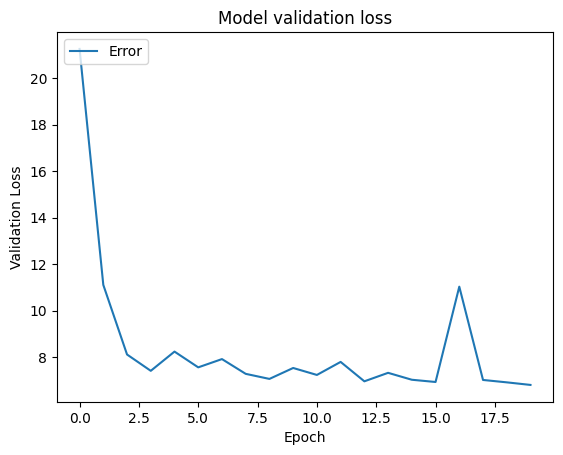

3111/3111 [==============================] - 2s 755us/step - loss: 6.8332


6.83320426940918

In [21]:
# testing neural network (full data)
fullDF = pd.read_csv("dataFull.csv")

# create model 
def baseline_model():
    # layers
    i = Input(shape=(6,))
    x = Dense(10, activation='relu')(i)
    y = Dense(10, activation='relu')(x)
    o = Dense(1)(y)
    model = Model(i, o)
    model.compile(loss="mse", optimizer= "adam")
    return model

model_full = baseline_model()
X = fullDF[['S','K','q','r','sigma','t']]
y = fullDF[['price']]
# z = fullDF[['fdm-price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 7)
history_full = model_full.fit(X_train, y_train, batch_size = 64, epochs = 20, verbose = 2, validation_split=0.2) # set batch size to 1

plt.plot(history_full.history['val_loss'])
plt.title('Model validation loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['Error', 'Test'], loc='upper left')
plt.show()
X_test_full = X_test
y_test_full = y_test
model_full.evaluate(x=X_test, y=y_test)

Epoch 1/20
141/141 - 0s - loss: 3439.3884 - val_loss: 639.5121 - 359ms/epoch - 3ms/step
Epoch 2/20
141/141 - 0s - loss: 312.1799 - val_loss: 163.2287 - 177ms/epoch - 1ms/step
Epoch 3/20
141/141 - 0s - loss: 109.5705 - val_loss: 77.4657 - 182ms/epoch - 1ms/step
Epoch 4/20
141/141 - 0s - loss: 69.4068 - val_loss: 61.9019 - 173ms/epoch - 1ms/step
Epoch 5/20
141/141 - 0s - loss: 62.8289 - val_loss: 60.1387 - 176ms/epoch - 1ms/step
Epoch 6/20
141/141 - 0s - loss: 62.0624 - val_loss: 58.7483 - 204ms/epoch - 1ms/step
Epoch 7/20
141/141 - 0s - loss: 61.2610 - val_loss: 58.3517 - 198ms/epoch - 1ms/step
Epoch 8/20
141/141 - 0s - loss: 60.8065 - val_loss: 57.7477 - 187ms/epoch - 1ms/step
Epoch 9/20
141/141 - 0s - loss: 60.5368 - val_loss: 57.1686 - 185ms/epoch - 1ms/step
Epoch 10/20
141/141 - 0s - loss: 59.9356 - val_loss: 56.8883 - 194ms/epoch - 1ms/step
Epoch 11/20
141/141 - 0s - loss: 58.9907 - val_loss: 56.0795 - 193ms/epoch - 1ms/step
Epoch 12/20
141/141 - 0s - loss: 58.3462 - val_loss: 55.4

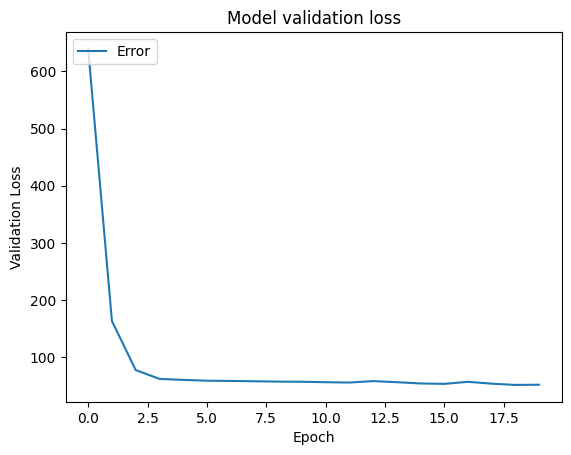

3111/3111 [==============================] - 3s 828us/step - loss: 42.7702


42.77017593383789

In [22]:
# testing neural network (sparse data)
sparseDF = pd.read_csv("dataSparse.csv")

def baseline_model():
    # create model
    i = Input(shape=(6,))
    x = Dense(10, activation='relu')(i)
    y = Dense(10, activation='relu')(x)
    o = Dense(1)(y)
    model = Model(i, o)
    model.compile(loss="mse", optimizer= "adam")
    return model

model_sparse = baseline_model()
X = sparseDF[['S','K','q','r','sigma','t']]

y = sparseDF[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 7)
history_sparse = model_sparse.fit(X_train, y_train, batch_size = 64, epochs = 20, verbose = 2, validation_split=0.2) # set batch size to 1, otherwise there are errors when trying to

plt.plot(history_sparse.history['val_loss'])
plt.title('Model validation loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['Error', 'Test'], loc='upper left')
plt.show()

model_sparse.evaluate(x=X_test_full, y=y_test_full)

Epoch 1/20
11198/11198 - 13s - loss: 34.1901 - val_loss: 14.5898 - 13s/epoch - 1ms/step
Epoch 2/20
11198/11198 - 12s - loss: 11.9006 - val_loss: 10.7925 - 12s/epoch - 1ms/step
Epoch 3/20
11198/11198 - 12s - loss: 9.6947 - val_loss: 8.7321 - 12s/epoch - 1ms/step
Epoch 4/20
11198/11198 - 12s - loss: 8.9990 - val_loss: 9.6501 - 12s/epoch - 1ms/step
Epoch 5/20
11198/11198 - 12s - loss: 8.1933 - val_loss: 7.2502 - 12s/epoch - 1ms/step
Epoch 6/20
11198/11198 - 13s - loss: 5.5272 - val_loss: 3.6432 - 13s/epoch - 1ms/step
Epoch 7/20
11198/11198 - 13s - loss: 3.6077 - val_loss: 3.0306 - 13s/epoch - 1ms/step
Epoch 8/20
11198/11198 - 12s - loss: 3.2278 - val_loss: 2.7356 - 12s/epoch - 1ms/step
Epoch 9/20
11198/11198 - 13s - loss: 3.0099 - val_loss: 3.3211 - 13s/epoch - 1ms/step
Epoch 10/20
11198/11198 - 13s - loss: 2.8941 - val_loss: 2.5265 - 13s/epoch - 1ms/step
Epoch 11/20
11198/11198 - 13s - loss: 2.7522 - val_loss: 2.8451 - 13s/epoch - 1ms/step
Epoch 12/20
11198/11198 - 13s - loss: 2.5384 - v

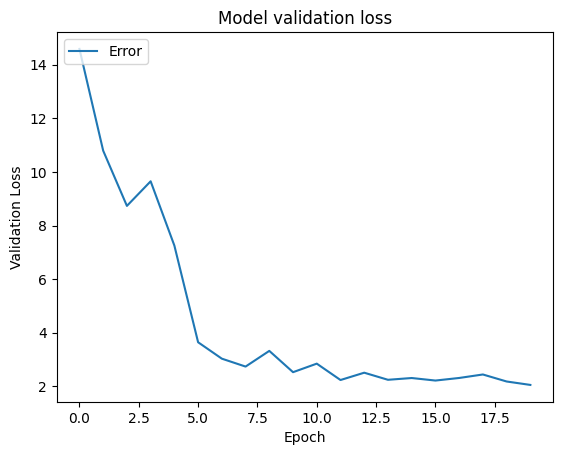

3111/3111 [==============================] - 3s 850us/step - loss: 2.5436
995328
12500
995328


In [23]:
# testing neural network (extremes data)
extremesDF = pd.read_csv("dataExtremes.csv")

def baseline_model():
    # create model
    i = Input(shape=(6,))
    x = Dense(10, activation='relu')(i)
    y = Dense(10, activation='relu')(x)
    o = Dense(1)(y)
    model = Model(i, o)
    model.compile(loss="mse", optimizer= "adam")
    return model

model_extremes = baseline_model()
X = extremesDF[['S','K','q','r','sigma','t']]
y = extremesDF[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 7)
history_extremes = model_extremes.fit(X_train, y_train, batch_size = 64, epochs = 20, verbose = 2, validation_split=0.2) # set batch size to 1, otherwise there are errors when trying to

plt.plot(history_extremes.history['val_loss'])
plt.title('Model validation loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['Error', 'Test'], loc='upper left')
plt.show()

model_extremes.evaluate(x=X_test_full, y=y_test_full)

tableOutput = pd.DataFrame({'Full':history_full.history['val_loss'], \
'Sparse':history_sparse.history['val_loss'], \
'Extremes':history_extremes.history['val_loss']}, columns=['Full', 'Sparse', 'Extremes'])
tableOutput.to_csv("tableResultsValidaton.csv")

print(len(fullDF.index))
print(len(sparseDF.index))
print(len(extremesDF.index))

# Summary
Data is very important for machine learning traning.